In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from config import C_COMMON, C_SINGLE, C_GRID
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [90]:
df_lr = []
for p in range(50, 600, 50):
    rmse_n = []
    for skn in skns:
        df_train_station = df_train[df_train['skn'] == skn].iloc[-p:]
        df_test_station = df_test[df_test['skn'] == skn]
        x_train, x_test = np.array(df_train_station[columns]), np.array(df_test_station[columns])
        y_train, y_test = np.array(df_train_station['data_in']), np.array(df_test_station['data_in'])
        
        linear_regression = LinearRegression()
        linear_regression.fit(x_train, y_train)
        y_pred = linear_regression.predict(x_test)
        
        rmse_n.append(mean_squared_error(y_test, y_pred, squared=False))
        df_lr.append({
            'skn': skn,
            'p': p,
            'rmse_lr': np.mean(rmse_n)
        })

In [92]:
df_lr = pd.DataFrame(df_lr)

In [96]:
df_lr[df_lr['skn'] == 54]

,skn,p,rmse_lr
0,54.0,50,8.709343
24,54.0,100,5.732004
48,54.0,150,5.016062
72,54.0,200,4.824114
96,54.0,250,4.724201
120,54.0,300,4.680309
144,54.0,350,4.706864
168,54.0,400,4.781971
192,54.0,450,4.724619
216,54.0,500,4.792276


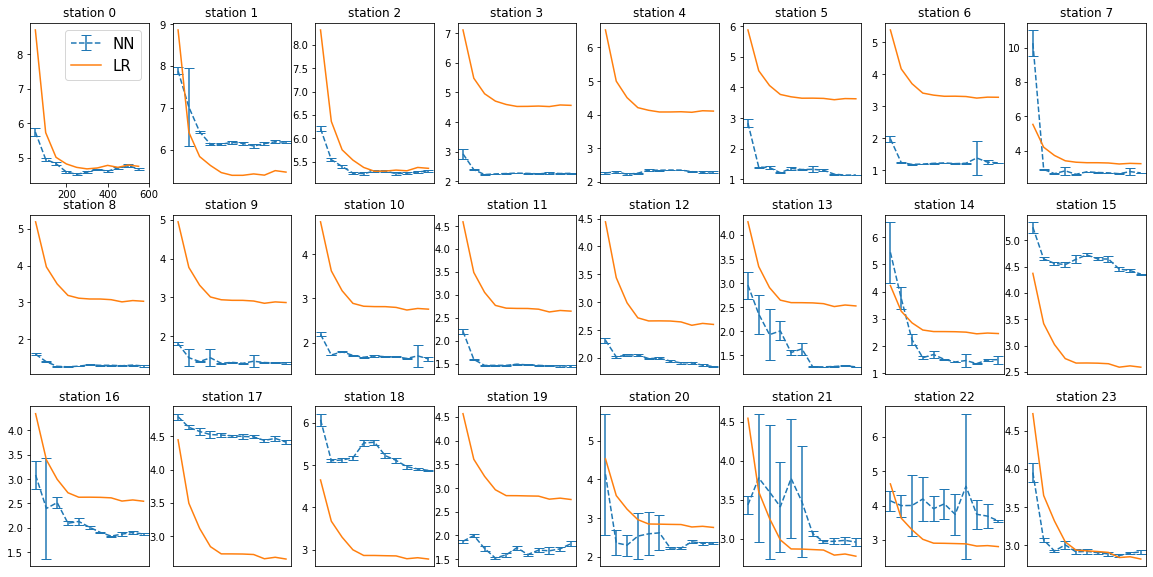

In [108]:
dir_name = '/home/yusukemh/github/yusukemh/StatisticalDownscaling/writeup/nn_hyperparameter_tuning/obtain_result/'
skns = pd.read_csv(dir_name + 'n_50_no_retrain.csv')['skn'].unique()
fig, axs = plt.subplots(3, 8, figsize=(20, 10))
for i, (ax, skn) in enumerate(zip(axs.flatten(), skns)):
    x, y, yerr = [], [], []
    for p in range(50, 600, 50):
        df = pd.read_csv(f'{dir_name}/n_{p}_no_retrain.csv')
        df = df[df['skn'] == skn]
        
        x.append(p)
        y.append(df['rmse_nn'].values)
        yerr.append(df['rmse_std_nn'].values)
    ax.set_title(f'station {i}')
    ax.errorbar(x=x, y=np.array(y).reshape(-1,), yerr=np.array(yerr).reshape(-1,), capsize=5, linestyle='--', label='NN')
    ax.errorbar(x=x, y=np.array(df_lr[df_lr['skn'] == skn]['rmse_lr']), label='LR')
    ax.set_xticks([])
axs[0,0].legend(fontsize=15)
axs[0,0].set_xticks([200, 400, 600])
fig.savefig('plots/05_nn_vs_lr')

In [68]:
df = pd.read_csv(
    '/home/yusukemh/sadow_lts/personal/yusukemh/pi_casc/processed_datasets/dataset_6grid_min_750.csv',
    # usecols=C_SINGLE + ['data_in', 'season_wet', 'skn']
)
skns = df['skn'].unique()

In [72]:
len(skns)

24

In [61]:
columns = C_SINGLE + ['season_wet']
df_train = df.query('fold != 4')
df_test = df.query('fold == 4')

In [66]:
y_lr = []
for p in range(50, 600, 50):
    rmse_n = []
    for skn in skns:
        df_train_station = df_train[df_train['skn'] == skn].iloc[-p:]
        df_test_station = df_test[df_test['skn'] == skn]
        x_train, x_test = np.array(df_train_station[columns]), np.array(df_test_station[columns])
        y_train, y_test = np.array(df_train_station['data_in']), np.array(df_test_station['data_in'])
        
        linear_regression = LinearRegression()
        linear_regression.fit(x_train, y_train)
        y_pred = linear_regression.predict(x_test)
        
        rmse_n.append(mean_squared_error(y_test, y_pred, squared=False))
    y_lr.append(np.mean(rmse_n))

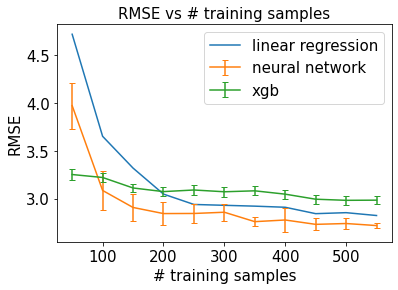

In [82]:
# station 784 is noisy
# skns = df_train['skn'].unique()
# skns = skns[skns != 784]

x = range(50, 600, 50)
y_nn, yerr_nn = np.zeros((len(x), len(skns))), np.zeros((len(x), len(skns)))
y_xgb, yerr_xgb = np.zeros((len(x), len(skns))), np.zeros((len(x), len(skns)))
for i, p in enumerate(x):
    # nn
    df = pd.read_csv(f'{dir_name}/n_{p}_no_retrain.csv')
    for j, skn in enumerate(skns):
        y_nn[i,j] = df[df['skn'] == skn]['rmse_nn']
        yerr_nn[i,j] = df[df['skn'] == skn]['rmse_std_nn']
        
    # xgb
    df = pd.read_csv(f'/home/yusukemh/github/yusukemh/StatisticalDownscaling/writeup/xgb_hyperparameter_tuning/obtain_result/n_{p}_.csv')
    for j, skn in enumerate(skns):
        y_xgb[i, j] = df[df['skn'] == skn]['rmse_xgb']
        yerr_xgb[i,j] = df[df['skn'] == skn]['rmse_std_xgb']
y_nn = y_nn.mean(axis=1)
yerr_nn = yerr_nn.mean(axis=1)
y_xgb = y_xgb.mean(axis=1)
yerr_xgb = yerr_xgb.mean(axis=1)

fig, ax = plt.subplots(1)
# simple plot for linear regression
ax.plot(x, y_lr, label='linear regression')
# error bar for NN
ax.errorbar(x=x[:], y=y_nn[:], yerr=yerr_nn[:], capsize=3, label='neural network')
# error bar for XGB
ax.errorbar(x=x[:], y=y_xgb[:], yerr=yerr_xgb[:], capsize=3, label='xgb')
ax.set_title('RMSE vs # training samples', fontsize=15)
ax.set_xlabel('# training samples', fontsize=15)
ax.set_ylabel('RMSE', fontsize=15)
ax.legend(fontsize=15)
ax.tick_params(labelsize=15)
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
fig.savefig('error_plot')
print()
fig.savefig('plots/05_vary_n_samples', bbox_inches='tight')